## Exploring saturation

An important computation in machine learning is dot product.
In the context of 8-bit floating point, dot products typically take float8 operands and return a higher precision result (e.g. float16), in which the summation is also evaluated.
Given the narrow dynamic range of float16, and the relatively large vector sizes in modern models (2K-12K), it is likely that some of these dot products will overflow the float16 dynamic range.  And even if the value `dot(a,b)` is within the finite range for some vectors `a` and `b`, it is possible for the result to overflow during computation.
As a simple example, if the partial sums are
```
[a a a a -a -a -a -a],
```
for a large finite value `a`, and if the vector is accumulated sequentially, the sum of four `a`s may overflow, 
even though the result is zero, perfectly in range.

Therefore, hardware implementations provide several options to treat overflow, even in float16: saturation, NaN on overflow, and overflow to infinity.

More precisely, if `v` in the following is the real value to be converted, rounded to the float16 significand precision, but with infinite-range exponent,
we can specify these behaviours by defining what is returned when `abs(v) > FLOAT_MAX`:

  - `OvSAT`: Saturation: `return sign(v)*FLOAT_MAX`
  - `OvNAN`: NaN on overflow: `return NaN`
  - `OvINF`: Infinity: `return sign(v)*Inf`

##### OvSAT 

A critique of `OvSAT` is that it may produce results that are arbitrarily wrong, as overflows early in accumulation may be silently ignored.
As an extreme example, consider an 8-bit format `float8` where the value `f = 224` is in the finite range.
Then the value `F = f * f = 50176.0` is close to `F16MAX = 65504.0 = float16.FLOAT_MAX`, and `F + F` is certainly larger than `F16MAX`.

Consider the dot product of the 4-vectors `a = [ f -f  f -f]`, `b = [f f f f]`.

Evaluated left-to-right, the result is
```
   ((f*f - f*f) + f*f) - f*f = 0
``` 
However, a particular implementation may choose to implement the addition in any order,
and alternative orders may be considerably more efficient in hardware.

Simulating different orders by permuting the vector elements, we observe the following results

  - `[ f -f  f -f] . [f f f f] = 0                     <- ` Correct answer
  - `[ -f -f f  f] . [f f f f] = -F16MAX + 2F `$\approx$`  F      <- ` Incorrect answer, but finite
  - `[ f  f -f -f] . [f f f f] = F16MAX - 2F `$\approx$`   -F      <- ` Incorrect answer, but finite

So the dot product can be maximally erroneous, with no signal that overflow has occurred.
[Footnote: Implementations might record overflow using other flag mechanisms, but the programmer 
who checks such flags can equally check the return value under `OvNAN` and `OvINF`.]

##### OvNAN

When implemented with `OvNAN`, the latter two orderings will yield `NaN`, signalling that overflow has occurred.

##### OvINF

When implemented with `OvINF`, the latter two orderings will yield `-Inf` and `+Inf` respectively, again signalling that overflow has occurred.  It might be thought that the sign of the infinity conveys more information than the single NaN, and in the experiments below, this will prove to be empirically somewhat true, but let us first observe that `OvINF` may often produce `NaN` results.
If, as is common, reduction is performed hierarchically, then the computation might be 
```
  [ f  f -f -f] . [f f f f] = [f f] . [f f] + [-f -f] . [f f] = Inf + -Inf = NaN
```

Thus, and particularly as vectors increase in length, `OvINF` appears to have the property that it will frequently return no more information than `OvNAN`.
This is explored experimentally below.



### Summary

Under the various options, we observe the following answers

| Computation               | OvSAT      | 0vINF | OvNAN |
| ------------------------- | ---------- | ----- | ----- |
| `[ f -f  f -f] . [f f f f]` | 0          | 0     | 0     |
| `[ -f -f f  f] . [f f f f]` | 34848.0    | Inf   | NaN   | 
| `[ f  f -f -f] . [f f f f]` | -34848.0   | -Inf  | NaN   |
| `[f f] . [f f] + [-f -f] . [f f]` | 0    | NaN   | NaN   |


## From theory to practice

The above discussion shows that `OvSAT` may be arbitrarily and silently incorrect, surely an alarming state of affairs.  And yet, it has been used in practice to train large deep learning models, apparently without notable ill effects.

In order to explore this question, let us empirically ask some simple questions:

  - Although in theory, errors can be large, how large are they in practice?
  - Does the +/-Inf signal offer potentially lower errors on average (e.g. replace +/-Inf with +/-F/2)?
  - How often does hierarchical reduction under `OvINF` in fact yield `NaN`?



In [1]:
# First, some preliminaries

import ml_dtypes
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

# Float formatter
def fstr(v):
  if np.isfinite(v):
    return repr(v)
  if np.isnan(v):
    return 'NaN'
  if v == np.inf:
    return "+Inf"
  if v == -np.inf:
    return "-Inf"
  raise ValueError(f"Bad {v=}")

def rms(x):
  return np.sqrt(((x)**2).mean())


To generate plausible distributions, we can look at the literature on low-precision training.
For example, from [1], we obtain these typical histograms of weights and activations in a transformer model:

| ![image](saturation-transformer-activations.png) | ![image](saturation-transformer-weights.png)|
| - | - |

We will try to match these qualitatively if not exactly, and we shall set the overall scale to best use dynamic range (i.e. if FLOAT_MAX=224, we will scale vectors to have maximum value 192).This value is approximately the square root of `float16.FLOAT_MAX`, as used in the theoretical worst-case examples above, but of course very few vector elements will have this value.  

[1] __8-bit Numerical Formats for Deep Neural Networks__, Badreddine Noune, Philip Jones, Daniel Justus, Dominic Masters, Carlo Luschi, 2022. https://arxiv.org/abs/2206.02915

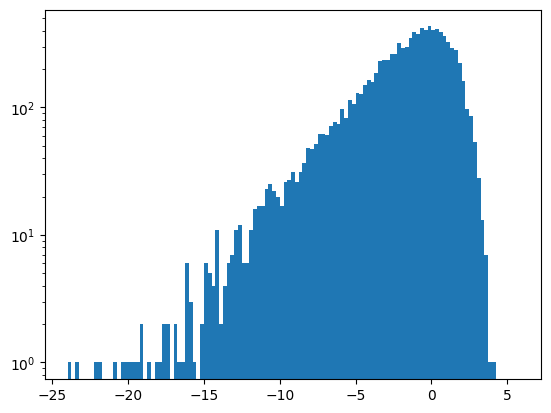

In [2]:
# Generate distributions qualitatively matching https://arxiv.org/abs/2206.02915
def randvals(n):
  v = np.random.randn(n)
  v = np.clip(v, -4, 4)
  return v**2 * np.sign(v)

v1 = randvals(10000)

plt.hist(np.log2(np.abs(v1)), bins=np.arange(-24,6,.25))
plt.yscale('log')

## Define partials type, and convert function

Let us choose `float16` as a partials type.

We implement `convert` with a flag to select between `OvSAT` and `OvINF`.
The behaviour of `OvNAN` can easily be inferred from the latter.

In [3]:
partials_dtype=np.float16
partials_max = ml_dtypes.finfo(partials_dtype).max
partials_min = ml_dtypes.finfo(partials_dtype).smallest_subnormal

OvSAT = True
OvINF = False
def convert(val, saturate=False):
  if np.isscalar(val):
    ovf = partials_max if saturate else np.inf
    if val > partials_max: 
      return ovf
    if val < -partials_max: 
      return -ovf
    return partials_dtype(val)
  else:
    if saturate:
      val[val > partials_max] = partials_max
      val[val < -partials_max] = -partials_max
    return val.astype(partials_dtype)

print(f'{float(convert(66666, OvSAT))=}')
print(f'{float(convert(66666, OvINF))=}')


float(convert(66666, OvSAT))=65504.0
float(convert(66666, OvINF))=inf


## Define dot product

We define a dot product that obeys the overflow flags.  It additionally takes a parameter `BLK` which defines the sub-block size over which accumulation is performed.

In [18]:
def mul_f8_to_f16(a, b, saturate=False):
    v = a.astype(partials_dtype) * b.astype(partials_dtype)
    return convert(v, saturate)

def sum_f16(v, saturate=False, BLK=16):
  total = partials_dtype(0)
  for i in range(0,len(v),BLK):
    partial = convert(np.sum(v[i:i+BLK]), saturate)
    total = convert(float(total) + float(partial), saturate)
  return total

def dot_f8(a, b, saturate=False, BLK=16):
  v = mul_f8_to_f16(a,b, saturate=saturate)
  return sum_f16(v, saturate=saturate, BLK=BLK)


And check that it agrees with theory above

In [19]:
# Pick an F8 type and make a value
f8_t = ml_dtypes.float8_e4m3fnuz
f = f8_t(224)

v2 = np.array([f, f, f, f])
check = lambda sat,blk,v1: dot_f8(np.array(v1), v2, saturate=sat, BLK=blk)
print(f'{check(OvSAT, 1, [f, -f, f, -f])=:<12} <-- Correct')
print(f'{check(OvSAT, 1, [f, f, -f, -f])=:<12} <-- Incorrect, silently')
print(f'{check(OvSAT, 1, [-f, -f, f, f])=:<12} <-- Incorrect, silently')
print()
print(f'{check(OvINF, 1, [f, -f, f, -f])=:<12} <-- Correct')
print(f'{check(OvINF, 1, [f, f, -f, -f])=:<12} <-- Incorrect, detectable')
print(f'{check(OvINF, 1, [-f, -f, f, f])=:<12} <-- Incorrect, detectable')
print()
print(f'{check(OvINF, 2, [-f, -f, f, f])=:<12} <-- NaN, rather than +/-Inf')


check(OvSAT, 1, [f, -f, f, -f])=0.0          <-- Correct
check(OvSAT, 1, [f, f, -f, -f])=-34848.0     <-- Incorrect, silently
check(OvSAT, 1, [-f, -f, f, f])=34848.0      <-- Incorrect, silently

check(OvINF, 1, [f, -f, f, -f])=0.0          <-- Correct
check(OvINF, 1, [f, f, -f, -f])=inf          <-- Incorrect, detectable
check(OvINF, 1, [-f, -f, f, f])=-inf         <-- Incorrect, detectable

check(OvINF, 2, [-f, -f, f, f])=nan          <-- NaN, rather than +/-Inf


/home/awf/anaconda3/envs/ml_dtypes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Generate random vectors, and dot-product them

Let us now generate random vectors, sized to match typical modern deep learning models.
For each pair, record the "true" answer, computed in float32, and the `OvSAT` and `OvINF` answers.


In [20]:
# Make some random data, scaled to max
def mkrand(n, scale):
  v = randvals(n)
  return v / np.abs(v).max() * scale

N = 2048
scale = 192
v1 = mkrand(N, scale).astype(f8_t)
print(f'{v1.max()=}')

errs = []
n_samples = 100000
n_inf = 0
with tqdm(range(n_samples)) as t: 
 for _ in t:
  v1 = mkrand(N, scale).astype(f8_t)
  v1 = np.abs(v1)
  v2 = mkrand(N, scale).astype(f8_t)

  dot_true = np.dot(v1.astype(float), v2.astype(float))
  dot_true16 = convert(dot_true, saturate=OvINF)
  dot_ovsat = dot_f8(v1, v2, saturate=OvSAT)
  dot_ovinf = dot_f8(v1, v2, saturate=OvINF)

  if np.isfinite(dot_ovsat) and np.isfinite(dot_ovinf):
    assert dot_ovinf == dot_ovsat

  if np.isfinite(dot_true16) and ~np.isfinite(dot_ovinf):
    n_inf = n_inf + 1
    t.set_postfix(n_inf=n_inf)
    pass

  errs.append((dot_true, dot_true16, dot_ovsat, dot_ovinf))

df = pandas.DataFrame(errs, columns=('true', 'true16', 'ovsat', 'ovinf'))

print(f'in-range results: {np.isfinite(df["true16"]).sum()/n_samples * 100:.1f}%')
print(f'in-range results, partials overflowed: {n_inf/n_samples * 100:.1f}%')


v1.max()=160


100%|██████████| 100000/100000 [03:16<00:00, 508.78it/s, n_inf=2938]


in-range results: 96.0%
in-range results, partials overflowed: 2.9%


## Examine the results

Let us first look at how many samples had answers that were in range.  This turns out to be reasonably high: about 95% of vectors of length 2048 are in range.  Furthermore, of that 95%, relatively few (2-3%) encountered overflow in the partials, which would have led to silently incorrect dot products. This is one indication why training is not greatly affected by the errors.  Nevertheless, 2-3% of values being arbitrarily wrong remains a potentially alarming situation.

We also count the number of times infinities cancelled to yield NaN.  Given that only a small percentage sees any Infs, it is unsuprising that this proportion is typically very low (typically 0 in the 10,000 element runs). 

in-range results: 96.0%
in-range results, partials overflowed: 2.7%
NaNs under ovinf: 0


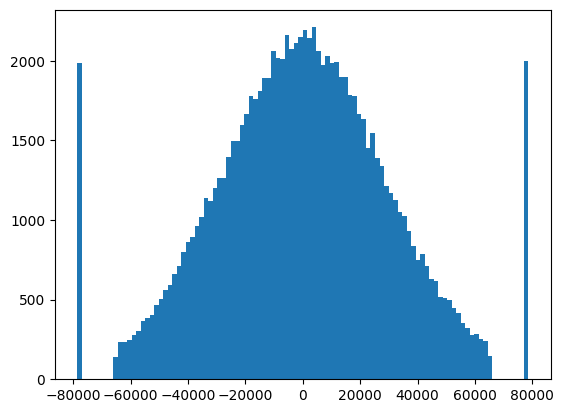

In [13]:
true16_is_finite = np.isfinite(df['true16'])
partials_overflowed = ~np.isfinite(df['ovinf'])

print(f'in-range results: {true16_is_finite.sum()/n_samples * 100:.1f}%')
print(f'in-range results, partials overflowed: {(true16_is_finite * partials_overflowed).sum()/n_samples * 100:.1f}%')
plt.hist(np.clip(df['true16'], *(partials_max*1.2*np.array([-1, 1]))), bins=100)

print(f"NaNs under ovinf: {np.isnan(df['ovinf']).sum()}")

## Replacing OvSAT with OvINF

A common reason to use OvSAT is simply "to avoid NaNs" - the practitioner does not know what to do in the presence of a non-finite result.  A simple fix is to replace +/-Inf with +/-FLOAT_MAX, and to replace NaN with 0. This offers no better or worse a theoretical guarantee (any true value could map to +/-Inf), nor does it promise to exactly emulate `OvSAT`, but it represents a principled way to handle overflows while avoiding silent incorrectness.

It might also be considered wise to to replace +/-Inf with zero, attempting to minimize the maximum error,
or to +/-FLOAT_MAX/2, making an assumption that a positive overflow will often correspond with a positive infinite-precision value.

To explore this question, we plot the true result against the result with saturation:

<Axes: xlabel='true'>

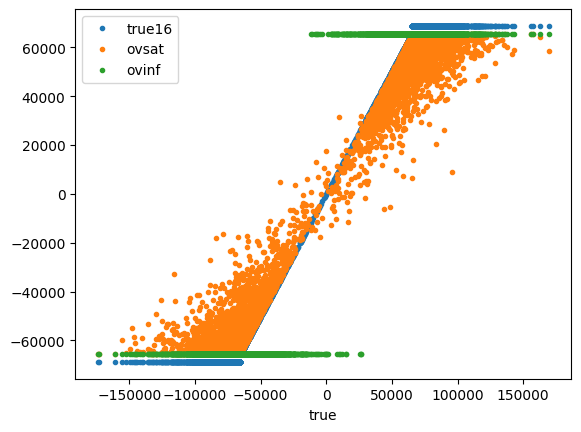

In [14]:

ovinf_best_fit = df[partials_overflowed].copy()
ovinf_best_fit[np.isnan(ovinf_best_fit['ovinf'])] = 0
ovinf_best_fit['ovinf'] = np.sign(ovinf_best_fit['ovinf']) * partials_max
ovinf_best_fit['true16'] = np.clip(ovinf_best_fit['true16'], *(1.05*partials_max*np.array([-1, 1])))

ovinf_best_fit.plot(x='true', style='.')
# plt.xlim([-partials_max, partials_max])
# plt.ylim([-partials_max, partials_max])


Observe that the orange dots are close to the Y=X line.
That is, although the answer under `OvSAT` can be arbitrarily wrong, for these vectors, it is often relatively close.
We can quantify this numerically, by computing RMS and Maximum error:

In [15]:

rms_err_ovsat = rms(ovinf_best_fit['ovsat'] - ovinf_best_fit['true'])
max_err_ovsat = np.abs(ovinf_best_fit['ovsat'] - ovinf_best_fit['true']).max()
print(f'{rms_err_ovsat= :.2f} {max_err_ovsat= :.2f}')

rms_err_ovsat= 19705.81 max_err_ovsat= 111032.35


And compare these numbers to the RMS and Maximum error for OvINF:

In [16]:
rms_err_ovinf = rms(ovinf_best_fit['ovinf'] - ovinf_best_fit['true'])
max_err_ovinf = np.abs(ovinf_best_fit['ovinf'] - ovinf_best_fit['true']).max()
print(f'{rms_err_ovinf= :.2f} {max_err_ovinf= :.2f}')

rms_err_ovinf= 19781.70 max_err_ovinf= 108611.63


Typically we find that the maximum and RMS errors (against the true float32 result) are roughly the same for both SAT and INF.

## Conclusion

From a theoretical point of view, the `OvINF` handling of overflow is attractive.
It offers a clear signal when overflow occurs, and a clear route to follow if a given
application would prefer to proceed as if the overflow had not happened.

In practice, `OvSAT` has proven effective in training deep learning models despite
its theoretical weaknesses.  This notebook suggests that for the distributions of values
encountered in deep learning, its average-case errors are not excessive.

Depending on a system's sensitivity to worst-case or average-case error, either 
procedure may be chosen.  It appears that an FP8 format would usefully support
both modes.  If a single mode were preferred, and given that `OvSAT` can be 
reasonably approximated using `OvINF` system, but not in the other direction, 
we might choose `OvINF` as the single mode.


In [21]:
!jupyter-nbconvert --to pdf saturation.ipynb 

[NbConvertApp] Converting notebook saturation.ipynb to pdf
/home/awf/anaconda3/envs/ml_dtypes/lib/python3.9/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (2.5).
Your version must be at least (2.14.2) but less than (4.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in saturation_files/
[NbConvertApp] Making directory ./saturation_files
[NbConvertApp] Writing 55861 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 229947 bytes to saturation.pdf
